In [1]:
import json
import os
from io import StringIO
from superlink.superlink import SuperLink
import mmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import swmmio

#np.warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
with open('../data/orifice.json', 'r') as j:
    inp = json.load(j)
    
superjunctions = pd.DataFrame(inp['superjunctions'])
superlinks = pd.DataFrame(inp['superlinks'])
junctions = pd.DataFrame(inp['junctions'])
links = pd.DataFrame(inp['links'])
orifices = pd.DataFrame(inp['orifices'])

In [3]:
model = swmmio.Model('/Users/mdbartos/Downloads/aa_0360min_025yr.inp')

In [4]:
junctionmap = pd.Series(np.arange(len(model.nodes())), model.nodes().index.values)
linkmap = pd.Series(np.arange(len(model.conduits())), model.conduits().index.values)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/swmmio/core.py:278: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  all_nodes = pd.concat([juncs_df, outfalls_df, storage_df])


In [5]:
tabular = pd.Series(junctionmap[11:].index, junctionmap[11:].values) 

In [6]:
new_superjunctions = pd.DataFrame(np.zeros((model.nodes().shape[0], superjunctions.shape[1])))
new_superjunctions.columns = superjunctions.columns

new_superjunctions['storage'] = 'functional'
new_superjunctions['z_inv'] = model.nodes()['InvertElev'].values
new_superjunctions['z_inv'] = 0.3048 * (new_superjunctions['z_inv'] - new_superjunctions['z_inv'].min())
new_superjunctions['id'] = new_superjunctions.index.values
new_superjunctions['table'] = tabular
new_superjunctions.loc[tabular.index, 'storage'] = 'tabular'
new_superjunctions.loc[new_superjunctions['storage'] == 'functional', 'c'] = 1
new_superjunctions['bc'] = False
new_superjunctions.loc[junctionmap['ZOF1'], 'bc'] = True

In [7]:
new_superjunctions

,A_sj,a,b,bc,c,h_0,id,storage,z_inv,table
0,0.0,0.0,0.0,False,1.0,0.0,0,functional,23.826216,NaN
1,0.0,0.0,0.0,False,1.0,0.0,1,functional,21.640800,NaN
2,0.0,0.0,0.0,False,1.0,0.0,2,functional,18.592800,NaN
3,0.0,0.0,0.0,False,1.0,0.0,3,functional,19.574256,NaN
4,0.0,0.0,0.0,False,1.0,0.0,4,functional,14.715744,NaN
5,0.0,0.0,0.0,False,1.0,0.0,5,functional,21.031200,NaN
6,0.0,0.0,0.0,False,1.0,0.0,6,functional,17.678400,NaN
7,0.0,0.0,0.0,False,1.0,0.0,7,functional,10.972800,NaN
8,0.0,0.0,0.0,False,1.0,0.0,8,functional,6.858000,NaN
9,0.0,0.0,0.0,False,1.0,0.0,9,functional,3.505200,NaN


In [8]:
new_superlinks = pd.DataFrame(np.zeros((model.conduits().shape[0], superlinks.shape[1])))
new_superlinks.columns = superlinks.columns

new_superlinks['sj_0'] = model.conduits()['InletNode'].map(junctionmap).values
new_superlinks['sj_1'] = model.conduits()['OutletNode'].map(junctionmap).values
new_superlinks = new_superlinks.sort_values(['sj_0', 'sj_1']).reset_index(drop=True)
j_0 = 4 * np.arange(0, new_superlinks.shape[0])
j_1 = 3 + j_0
new_superlinks['j_0'] = j_0
new_superlinks['j_1'] = j_1
new_superlinks['id'] = new_superlinks.index.values

In [9]:
new_superlinks

,id,j_0,j_1,sj_0,sj_1
0,0,0,3,0,21
1,1,4,7,1,19
2,2,8,11,2,13
3,3,12,15,3,15
4,4,16,19,4,14
5,5,20,23,5,19
6,6,24,27,6,14
7,7,28,31,7,16
8,8,32,35,8,18
9,9,36,39,9,17


In [10]:
new_links = pd.DataFrame(np.zeros((3 * model.conduits().shape[0], links.shape[1])))
new_links.columns = links.columns
new_links['ctrl'] = False
new_links['k'] = np.repeat(new_superlinks.index.values, 3)

lengths = 0.3048 * model.conduits()['Length']

first_lengths = np.minimum(0.1*lengths, 10)
last_lengths = np.minimum(0.1*lengths, 10)
remaining_lengths = lengths - first_lengths - last_lengths
assert ((remaining_lengths + first_lengths + last_lengths) == lengths).all()
link_lengths = np.column_stack([first_lengths, remaining_lengths, last_lengths]).ravel()
new_links['dx'] = link_lengths
new_links['shape'] = 'circular'
new_links['n'] = model.conduits().iloc[new_links['k']].loc[:, 'ManningN'].values
new_links['g1'] = model.conduits().iloc[new_links['k']].loc[:, 'Geom1'].values

j_0 = np.arange(4 * len(new_superlinks))
j_1 = np.arange(4 * len(new_superlinks))
jj_01 = np.column_stack([j_0[:-1], j_1[1:]])
jj_01 = jj_01[np.delete(np.arange(len(jj_01)), np.arange(3, len(jj_01), 4))]
new_links[['j_0', 'j_1']] = jj_01
new_links['id'] = new_links.index.values

In [11]:
new_links

,A_c,C,Q_0,ctrl,dx,g1,g2,g3,id,j_0,j_1,k,n,shape
0,0.0,0.0,0.0,False,10.000000,1.0,0.0,0.0,0,0,1,0,0.010,circular
1,0.0,0.0,0.0,False,319.434424,1.0,0.0,0.0,1,1,2,0,0.010,circular
2,0.0,0.0,0.0,False,10.000000,1.0,0.0,0.0,2,2,3,0,0.010,circular
3,0.0,0.0,0.0,False,5.634533,1.0,0.0,0.0,3,4,5,1,0.010,circular
4,0.0,0.0,0.0,False,45.076262,1.0,0.0,0.0,4,5,6,1,0.010,circular
5,0.0,0.0,0.0,False,5.634533,1.0,0.0,0.0,5,6,7,1,0.010,circular
6,0.0,0.0,0.0,False,10.000000,1.0,0.0,0.0,6,8,9,2,0.010,circular
7,0.0,0.0,0.0,False,263.845000,1.0,0.0,0.0,7,9,10,2,0.010,circular
8,0.0,0.0,0.0,False,10.000000,1.0,0.0,0.0,8,10,11,2,0.010,circular
9,0.0,0.0,0.0,False,5.561381,1.0,0.0,0.0,9,12,13,3,0.010,circular


In [12]:
new_junctions = pd.DataFrame(np.zeros((4 * model.conduits().shape[0], junctions.shape[1])))
new_junctions.columns = junctions.columns
new_junctions['id'] = new_junctions.index.values
new_junctions['k'] = np.repeat(new_superlinks.index.values, 4)
dz_k = (new_superjunctions.loc[new_superlinks['sj_0'].values, 'z_inv'].values
        - new_superjunctions.loc[new_superlinks['sj_1'].values, 'z_inv'].values)
dx_k = new_links.groupby('k').sum()['dx'].values
# Remember to do unit conversion
dzdx = pd.Series(dz_k / dx_k)
drop = new_links['k'].map(dzdx) * new_links.groupby('k').cumsum()['dx']
first_depth = new_superjunctions.loc[new_superlinks['sj_0'].loc[new_links['k'].values].values, 'z_inv']
drop.index = new_links['j_1'].loc[drop.index.values]
first_depth.index = drop.index
z_inv = first_depth - drop
new_junctions.loc[z_inv.index, 'z_inv'] = z_inv

first_depth = new_superjunctions.loc[new_superlinks['sj_0'].loc[new_links['k'].values].values, 'z_inv']
first_depth.index = new_superlinks['j_0'].loc[new_links['k'].values].values
first_depth = first_depth.groupby(level=0).first()
new_junctions.loc[first_depth.index, 'z_inv'] = first_depth.values
new_junctions['A_s'] = new_junctions['k'].map(new_links.groupby('k').mean()['g1']).values

In [13]:
new_junctions

,A_s,h_0,id,k,z_inv
0,1.0,0.0,0,0,2.382622e+01
1,1.0,0.0,1,0,2.376183e+01
2,1.0,0.0,2,0,2.170518e+01
3,1.0,0.0,3,0,2.164080e+01
4,1.0,0.0,4,1,2.164080e+01
5,1.0,0.0,5,1,2.133600e+01
6,1.0,0.0,6,1,1.889760e+01
7,1.0,0.0,7,1,1.859280e+01
8,1.0,0.0,8,2,1.859280e+01
9,1.0,0.0,9,2,1.856059e+01


In [14]:
new_orifices = pd.DataFrame(np.zeros((model.orifices().shape[0], orifices.shape[1])))
new_orifices.columns = orifices.columns

new_orifices['id'] = new_orifices.index.values
new_orifices['sj_0'] = model.orifices()['InletNode'].map(junctionmap).values
new_orifices['sj_1'] = model.orifices()['OutletNode'].map(junctionmap).values
new_orifices['A'] = 1.

In [15]:
new_orifices

,A,id,sj_0,sj_1
0,1.0,0,12,0
1,1.0,1,21,1
2,1.0,2,19,2
3,1.0,3,15,4
4,1.0,4,11,3
5,1.0,5,20,5
6,1.0,6,13,6
7,1.0,7,14,7
8,1.0,8,16,8
9,1.0,9,18,9


In [16]:
with open('/Users/mdbartos/Downloads/aa_0360min_025yr.inp', 'r') as f:
    s = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
    begin = s.find(b'[CURVES]')
    end = s[begin:].find(b'[TIMESERIES]')
    curves = s[begin:begin+end].decode()

In [17]:
curves = curves[curves.find('--\n')+3:]

In [18]:
split = curves.split('\n\n')

In [19]:
new_storages = {}

for elem in split:
    try:
        storage = pd.read_csv(StringIO(elem), sep='\t', header=None)
        name = storage[0].str.strip()[0]
        h = 0.3048 * storage[2].values
        A = 0.3048**2 * storage[3].values
        new_storages[name] = {}
        new_storages[name]['h'] = h
        new_storages[name]['A'] = A
    except:
        print(elem)

In [20]:
with open('/Users/mdbartos/Downloads/aa_0360min_025yr.inp', 'r') as f:
    s = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
    begin = s.find(b'[STORAGE]')
    end = s[begin:].find(b'\n\n')
    table = s[begin:begin+end].decode()

In [21]:
# Storage names are same as storage id
pd.read_csv(StringIO('\n'.join(table.split('\n')[4:])), sep='\t', header=None)

,0,1,2,3,4,5,6,7,8,9
0,93-49743,874.22,14.96,0.0,TABULAR,93-49743,NaN,,32993.0,0.0
1,93-49868,888.17,10.00,0.0,TABULAR,93-49868,NaN,,50000.0,0.0
2,93-49919,868.00,10.00,0.0,TABULAR,93-49919,NaN,,50000.0,0.0
3,93-49921,846.00,10.00,0.0,TABULAR,93-49921,NaN,,50000.0,0.0
4,93-50074,858.28,13.72,0.0,TABULAR,93-50074,NaN,,50000.0,0.0
5,93-50076,832.50,10.00,0.0,TABULAR,93-50076,NaN,,50000.0,0.0
6,93-50077,810.00,10.00,0.0,TABULAR,93-50077,NaN,,50000.0,0.0
7,93-50081,821.50,10.00,0.0,TABULAR,93-50081,NaN,,50000.0,0.0
8,93-50225,871.00,20.00,0.0,TABULAR,93-50225,NaN,,36888.0,0.0
9,93-90357,879.00,10.00,0.0,TABULAR,93-90357,NaN,,50000.0,0.0


In [22]:
from swmmtoolbox import swmmtoolbox

In [23]:
if not os.path.exists('swmm_runoff.csv'):
    filename = '/Users/mdbartos/Downloads/aa_0360min_025yr.out'
    c = swmmtoolbox.catalog(filename)
    c = pd.DataFrame(c)
    item_names = c[c[0] == 'subcatchment'][1].values
    items = pd.Series(np.repeat(item_names, 1)).astype(str)
    var_indices = pd.Series(np.tile([4], len(item_names))).astype(str)
    item_types = pd.Series(np.repeat('subcatchment', len(items))).astype(str)
    labels = (item_types + ',' + items + ',' + var_indices).values.tolist()
    runoff = swmmtoolbox.fast_extract(filename, *labels)
    runoff.to_csv('swmm_runoff.csv')
else:
    runoff = pd.read_csv('swmm_runoff.csv', index_col=0)
    runoff.index = pd.to_datetime(runoff.index)

In [24]:
runoff.columns = model.subcatchments()['Outlet'].loc[pd.Series(runoff.columns).str.split('_').str[1].values].values
runoff = (runoff.T).groupby(level=0).sum().T
runoff.columns = pd.Series(runoff.columns).map(junctionmap).values

header "[Polygons]" not found in "/Users/mdbartos/Downloads/aa_0360min_025yr.inp"
returning empty dataframe


In [25]:
if False:
    # Boundary stage is fixed at 0
    item_names = c[c[1] == 'ZOF1'][1].values
    items = pd.Series(np.repeat(item_names, 1)).astype(str)
    var_indices = pd.Series(np.tile([0], len(item_names))).astype(str)
    item_types = pd.Series(np.repeat('node', len(items))).astype(str)
    labels = (item_types + ',' + items + ',' + var_indices).values.tolist()
    boundary_stage = swmmtoolbox.fast_extract(filename, *labels)

In [26]:
Q_in = np.zeros((runoff.shape[0], new_superjunctions.shape[0]))
Q_in[:, runoff.columns.values] = runoff.values
Q_in *= 0.028316847
Q_in = pd.DataFrame(Q_in, index=runoff.index)
H_bc = np.ones((runoff.shape[0], new_superjunctions.shape[0]))
H_bc *= 1e-5
H_bc = pd.DataFrame(H_bc, index=runoff.index)

In [27]:
new_superjunctions['h_0'] = 1e-5
new_junctions['h_0'] = 1e-5

In [28]:
time_range = Q_in.index.values

In [29]:
u = np.ones(len(new_orifices)).reshape(-1, 1)

In [30]:
# Instantiate superlink object
superlink = SuperLink(new_superlinks, new_superjunctions, new_links, new_junctions,
                      orifices=new_orifices, storages=new_storages)

# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

# Set initial time
t_prev = time_range[0].astype(int)

# For each time step...
for t_next in time_range[1:500]:
    # Compute time difference between steps
    dt = (int(t_next) - t_prev) / 1e9
    # Get next stage boundary condition
    H_bc_next = H_bc.loc[t_next].values
    # Get next flow input
    Q_in_next = Q_in.loc[t_next].values
    # Run superlink algorithm
    superlink.step(H_bc=H_bc_next, Q_in=Q_in_next, dt=dt, u=None)
    # Store previous timestamp
    t_prev = int(t_next)
    # Store results
    ts.append(t_next)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_in_next)
    H_bcs.append(H_bc_next)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [31]:
H = np.vstack(Hs)

In [32]:
sns.set_palette('husl')

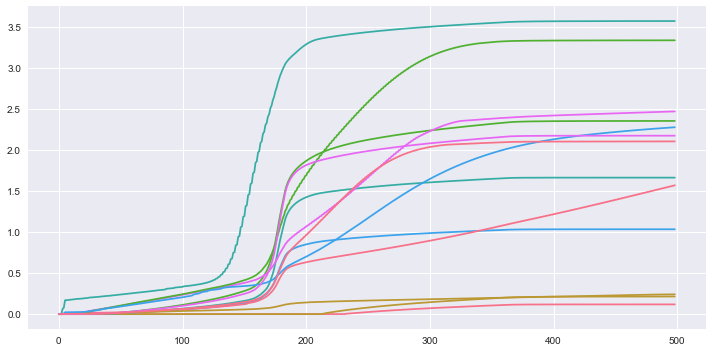

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(H[:,2] - H[:,2].min())
plt.plot(H[:,8] - H[:,8].min())
plt.plot(H[:,11] - H[:,11].min())
plt.plot(H[:,12] - H[:,12].min())
plt.plot(H[:,13] - H[:,13].min())
plt.plot(H[:,14] - H[:,14].min())
plt.plot(H[:,15] - H[:,15].min())
plt.plot(H[:,16] - H[:,16].min())
plt.plot(H[:,17] - H[:,17].min())
plt.plot(H[:,18] - H[:,18].min())
plt.plot(H[:,19] - H[:,19].min())
plt.plot(H[:,20] - H[:,20].min())
plt.plot(H[:,21] - H[:,21].min())
plt.tight_layout()

In [34]:
u = np.ones(len(new_orifices))

In [35]:
# Instantiate superlink object
superlink = SuperLink(new_superlinks, new_superjunctions, new_links, new_junctions,
                      orifices=new_orifices, storages=new_storages)

# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

# Set initial time
t_prev = time_range[0].astype(int)

# For each time step...
for t_next in time_range[1:500]:
    # Compute time difference between steps
    dt = (int(t_next) - t_prev) / 1e9
    # Get next stage boundary condition
    H_bc_next = H_bc.loc[t_next].values
    # Get next flow input
    Q_in_next = Q_in.loc[t_next].values
    # Run superlink algorithm
    superlink.step(H_bc=H_bc_next, Q_in=None, dt=dt, u=u)
    # Store previous timestamp
    t_prev = int(t_next)
    # Store results
    ts.append(t_next)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_in_next)
    H_bcs.append(H_bc_next)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [36]:
H = np.vstack(Hs)

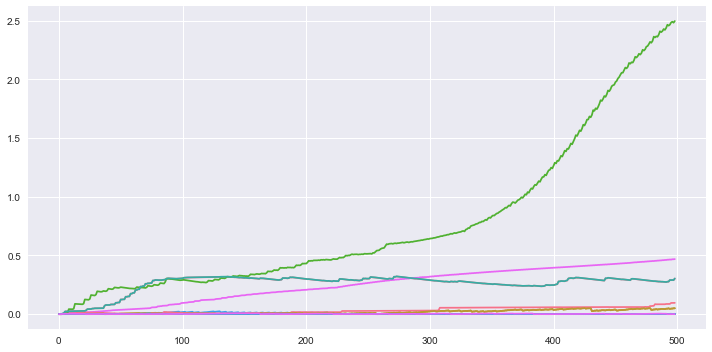

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(H[:,2] - H[:,2].min())
plt.plot(H[:,8] - H[:,8].min())
plt.plot(H[:,11] - H[:,11].min())
plt.plot(H[:,12] - H[:,12].min())
plt.plot(H[:,13] - H[:,13].min())
plt.plot(H[:,14] - H[:,14].min())
plt.plot(H[:,15] - H[:,15].min())
plt.plot(H[:,16] - H[:,16].min())
plt.plot(H[:,17] - H[:,17].min())
#plt.plot(H[:,18] - H[:,18].min())
plt.plot(H[:,19] - H[:,19].min())
plt.plot(H[:,20] - H[:,20].min())
plt.plot(H[:,21] - H[:,21].min())
plt.tight_layout()

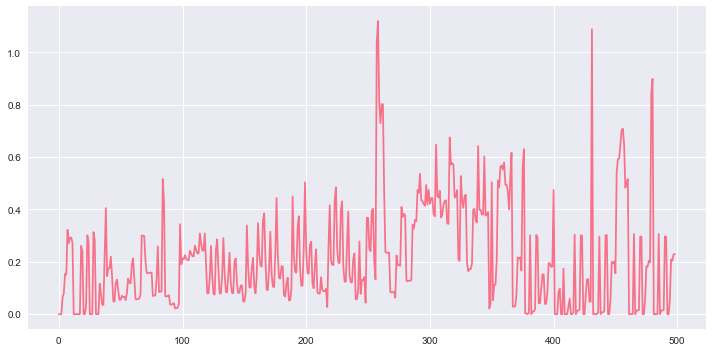

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(H[:,18] - H[:,18].min())
plt.tight_layout()